In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('karpathy/makemore/names.txt', 'r').read().splitlines()

In [22]:
chars = sorted(list(set(''.join(words))))   #先去重再变为列表，再排序
stoi = {s:i+1 for i,s in enumerate(chars)}   #i+1是因为需要将.设置为0号
stoi['.'] = 0 
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

从loss值可以看出，用该神经网络的方法可以训练出比first中更为优秀的结果？  
用同样的数据训练，并用相同的数据计算loss并不能避免overfitting的产生：  
将数据集分成三份：training split, dev split, validation split 8/1/1  
training split:训练模型参数  
dev split:训练超参数，例如隐藏层的大小，嵌入的大小，正则化参数  
validation split：评估最终模型性能  

In [23]:
block_size = 3 #context length: how many characters do we take to predict the next one
def build_dataset(words):
    X,Y = [],[]  #x:INPUTS;y:LABLES
    for w in words:
        #print(w)
        context = [0]*block_size  #初始化一个长度为block_size的全零列表作为初始上下文
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  #crop and append
            #这行代码更新上下文：它去掉最旧的字符（即列表的第一个元素）并添加当前字符的新索引。这使得上下文始终包含最新的3个字符。
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y
    
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [24]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

"embedding" 通常指将高维数据（如单词、图像等）映射到低维空间的技术,下面实现
我们现在就把（228146，3）这样的结构->one_hot(228146,3,27)->(228146,3,2)
27：有27个字母，如果不映射的话，输入数据还需要进行one_hot

C = torch.randn(27,2)
emb = C[X]  #embedding映射
emb.shape    

In [25]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2),generator = g,requires_grad=True)  #embedding参数
W1 = torch.randn((6,100),generator = g,requires_grad=True)
b1 = torch.randn(100,generator = g,requires_grad=True)  #hidden layer 参数
W2 = torch.randn((100,27),generator = g,requires_grad=True)
b2 = torch.randn(27,generator = g,requires_grad=True)  #output layer 参数
parameters = [C,W1,b1,W2,b2]
print(sum(p.nelement()for p in parameters))

3481


也就是把3*27个integar->27one_hot的过程简化为3 * 2个float->27ome_hot的过程  
#为了方便后续的计算，我们选择去对这个3 * 2的部分进行拼接（使用view函数解决）  
h = torch.tanh(emb.view(-1,6) @ W1 + b1)  

In [26]:
lre = torch.linspace(-3,0,1000)  #从0.001到1选出合适的learning_rate
lrs = 10**lre  #下面两个cell也是为了确定合适的learning_rate，确定好之后也可以不运行这几个cell

In [27]:
lossi = [] 
lri = []  #记录learning_rate

for i in range(1000):
    #minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,6) @ W1 + b1)  #hidden layer output
    logits = h @ W2 + b2 #最终输出 logits
    loss = F.cross_entropy(logits,Ytr[ix])  #高效安全的函数,计算交叉熵损失，logits 是模型的预测值，Y 是真实标签。
    print(loss.item())
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    #update
    lr = lrs[i]
    for p in parameters:
        p.data += -lr*p.grad
    lri.append(lre[i])
    lossi.append(loss.item())

19.082855224609375
17.55207061767578
19.648683547973633
21.5662784576416
20.8645076751709
19.416730880737305
17.501354217529297
20.893770217895508
20.614500045776367
18.03006935119629
21.496549606323242
16.652559280395508
19.013267517089844
18.959514617919922
18.87474250793457
20.014877319335938
17.88552474975586
17.88271141052246
18.795162200927734
20.354202270507812
17.80750846862793
20.590970993041992
19.899078369140625
19.362394332885742
17.280078887939453
17.19379234313965
18.932146072387695
19.09586524963379
20.306133270263672
15.788084030151367
19.269855499267578
17.263980865478516
19.11944580078125
17.846445083618164
19.72344207763672
19.47026824951172
16.760807037353516
20.118072509765625
20.895484924316406
18.790050506591797
19.241966247558594
17.67842674255371
17.768310546875
19.532943725585938
19.072317123413086
18.406890869140625
20.60852813720703
18.57343292236328
19.81158447265625
19.42835235595703
20.548328399658203
19.72868537902832
13.630572319030762
17.81847190856933

<class 'list'> <class 'list'>


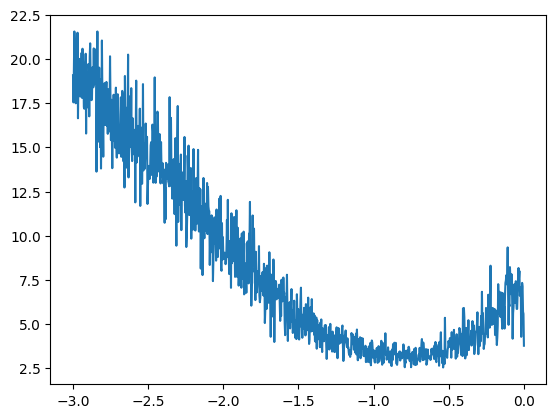

In [28]:
print(type(lri),type(lossi))
plt.plot(lri, lossi)

In [29]:
#MLP revisited
n_embd = 10  #the dimensionality of the character embedding vectors
n_hidden = 200  #the number of neurons in the hidden layer of the 
#需要进行初始化的优化
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),generator = g)
W1 = torch.randn((n_embd * block_size,n_hidden),generator = g) * (5/3)/((n_embd * block_size)**0.5)
#防止神经元过度饱和，以至于梯度消失而死亡
#b1 = torch.randn(n_hidden, generator = g) * 0.01  
W2 = torch.randn((n_hidden,vocab_size),generator = g) * 0.01  
b2 = torch.randn(vocab_size,generator = g) * 0  #使得27个字符初始的概率保持，初始化loss能够减小

#缩放#BatchNorm parameters
bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C,W1,W2,b2,bngain,bnbias]
print(sum(p.nelement() for p in parameters)) #number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [31]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
stepi = []
for i in range(max_steps):
    
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,), generator = g)
    Xb, Yb = Xtr[ix],Ytr[ix]
    
    #forward pass
    emb = C[Xb]  
    embcat = emb.view(emb.shape[0],-1)
    if i == 0:
        print("C.shape = ",C.shape)
        print("Xb.shape = ",Xb.shape)
        print("emb.shape = ",emb.shape)
        print("embcat.shape = ",embcat .shape)
    #linear layer 权重层
    hpreact = embcat @ W1 #+ b1  #hidden layer per-activation
    '''
    这里我们不希望hpreact过于大或者过于小，所以我们采用batchnormalization去使得这一层呈现高斯分布的特征
    '''
    #BatchNorm layer  归一化层（——可以散布于整个神经网络的层）
    bnmeani = hpreact.mean(0,keepdim = True)   #当使用这一步时，便不再需要bias，因为此时nb项会因为mean以后再减去mean而不起任何作用
    #0代指的是对一列的东西->取平均值 比如(32,200)->(1,200)
    bnstdi = hpreact.std(0,keepdim = True)
    hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias #batch normalizationl
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnmean_running +0.001 * bnstdi  #0.001:torch.nn当中的momentum
        #关于momentum:如果使用稍高一些的batch_size,那么则可以尝试使用更高的momentum(如0.1)
        #如果在较小的批量上选择较大的momentum,那么可能会使bnmeam_running和bnstd_running在训练期间产生较大波动
        #从而使得模型不能正确收敛
    #Non-linearity  #非线性层
    h = torch.tanh(hpreact)  #hidden layer
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, Yb)  #loss function
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.1 if i < 20000 else 0.0005 #step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d} / {max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    stepi.append(i)

C.shape =  torch.Size([27, 10])
Xb.shape =  torch.Size([32, 3])
emb.shape =  torch.Size([32, 3, 10])
embcat.shape =  torch.Size([32, 30])
      0 /  200000:3.3239
  10000 /  200000:2.0322
  20000 /  200000:2.5675
  30000 /  200000:2.0406
  40000 /  200000:2.1946
  50000 /  200000:1.8209
  60000 /  200000:2.0573
  70000 /  200000:2.3175
  80000 /  200000:2.4076
  90000 /  200000:2.0913
 100000 /  200000:2.1871
 110000 /  200000:2.4144
 120000 /  200000:1.6621
 130000 /  200000:2.0302
 140000 /  200000:2.3007
 150000 /  200000:2.0960
 160000 /  200000:2.0451
 170000 /  200000:2.4736
 180000 /  200000:2.1630
 190000 /  200000:2.1798


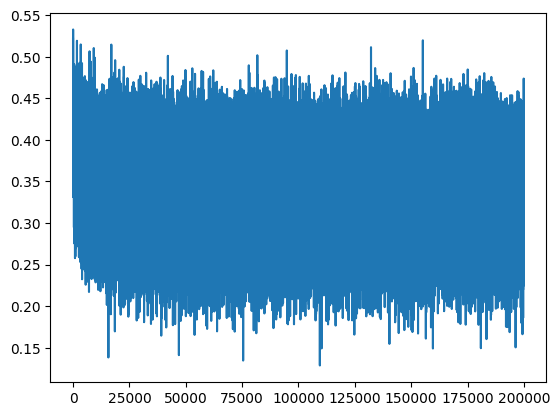

In [32]:
plt.plot(stepi,lossi)

In [33]:
#caliberate the batch norm at the end of training
#在训练结束后对批量归一化（Batch Normalization）进行校准
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1
    #measure the mean over the entire training set
    bnmean = hpreact.mean(0,keepdim = True)
    bnstd = hpreact.std(0,keepdim = True)

In [37]:
@torch.no_grad()  #让下面这个函数执行的所有变量都无grad也就是no_grad,从而不能进行反向传播
#adecorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0],-1)
    hpreact = embcat @ W1  #hidden layer per-activation
    hpreact = bngain * (hpreact - bnmean)/bnstd+ bnbias #batch normalizationl
    h = torch.tanh(hpreact)  #hidden layer
    logits = h @ W2 + b2  #output layer
    loss = F.cross_entropy(logits, y)  #loss function
    print(split,loss.item())
split_loss('train')
split_loss('val')

train 2.1418704986572266
val 2.1568679809570312


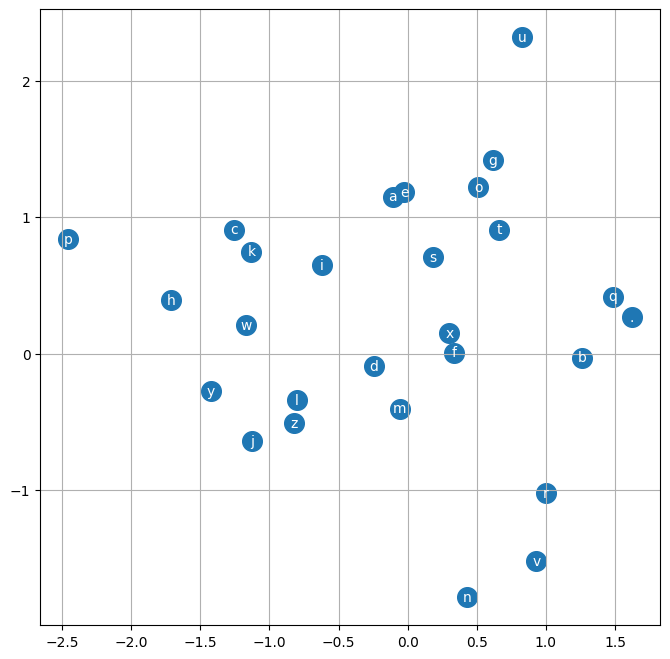

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data,s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha = "center",va = "center",color="white")
plt.grid('minor')

In [39]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb @ W1 + b1)
        logits = h @ W2 + b2 #最终输出 logits
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x10 and 30x200)